This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray CfRadial1 backend

In this example, we read and write CfRadial1 data files using the xarray `wradlib-cfradial1` backend.

In [1]:
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()

/home/runner/micromamba-root/envs/wradlib-notebooks/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load CfRadial1 Volume Data

In [2]:
fpath = "netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR.nc"
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_cfradial1_dataset(f)

### Inspect RadarVolume

In [3]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 9)
Elevation(s): (0.5, 1.1, 1.8, 2.6, 3.6, 4.7, 6.5, 9.1, 12.8)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2008-06-04T00:15:03Z'
    time_coverage_end    <U20 '2008-06-04 00:22:17Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_7' 'sweep_8'
    sweep_fixed_angle    (sweep) float32 0.4999 1.099 1.802 ... 6.498 9.102 12.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol[0])

<xarray.Dataset>
Dimensions:                    (azimuth: 483, range: 996)
Coordinates:
    sweep_mode                 <U20 'azimuth_surveillance'
    rtime                      (azimuth) datetime64[ns] 2008-06-04T00:15:34 ....
  * range                      (range) float32 150.0 300.0 ... 1.494e+05
  * azimuth                    (azimuth) float32 0.0 0.75 1.5 ... 358.5 359.2
    elevation                  (azimuth) float32 ...
    latitude                   float64 ...
    longitude                  float64 ...
    altitude                   float64 ...
    time                       datetime64[ns] 2008-06-04T00:15:03
Data variables: (12/17)
    sweep_number               int32 ...
    prt_mode                   |S32 ...
    follow_mode                |S32 ...
    sweep_fixed_angle          float32 0.4999
    pulse_width                (azimuth) timedelta64[ns] ...
    prt                        (azimuth) timedelta64[ns] ...
    ...                         ...
    r_calib_index              (azimuth) int8 ...
    measured_transmit_power_h  (azimuth) float32 ...
    measured_transmit_power_v  (azimuth) float32 ...
    scan_rate                  (azimuth) float32 ...
    DBZ                        (azimuth, range) float32 ...
    VR                         (azimuth, range) float32 ...

### Georeferencing

In [6]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

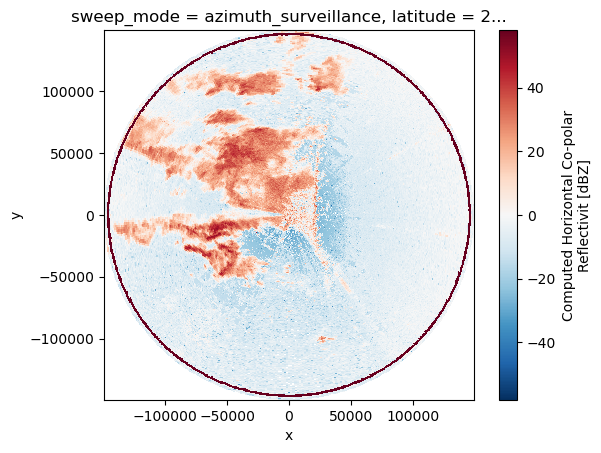

In [7]:
swp.DBZ.plot.pcolormesh(x="x", y="y")
pl.gca().set_aspect("equal")

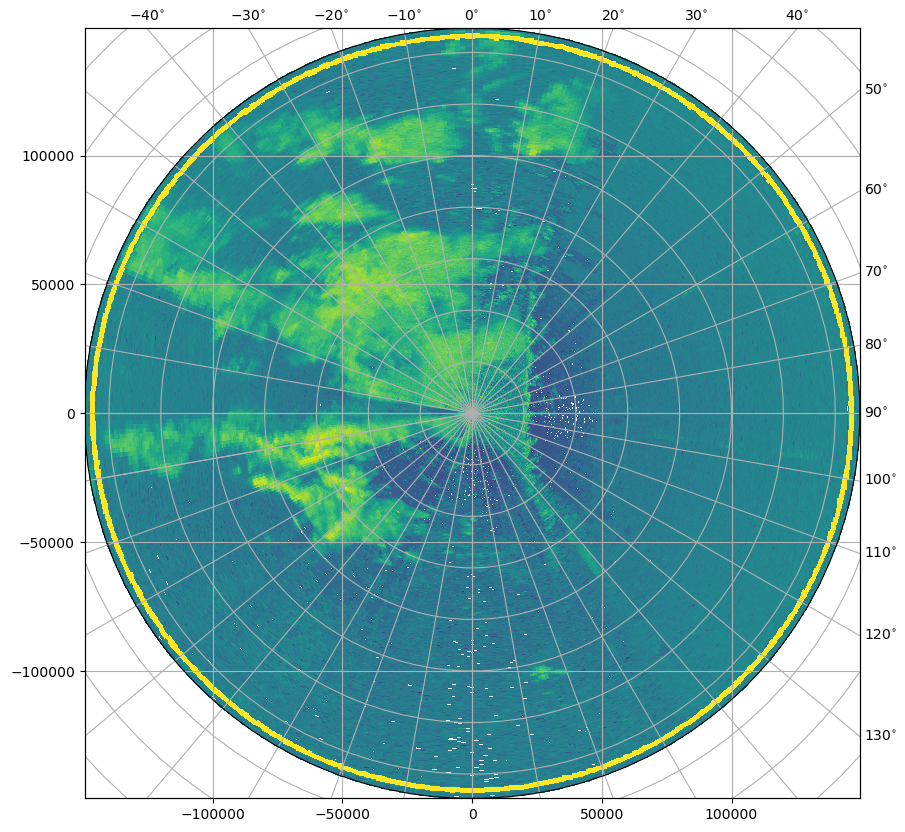

In [8]:
fig = pl.figure(figsize=(10, 10))
swp.DBZ.wradlib.plot_ppi(proj="cg", fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=120.43350219726562 +lat_0=22.52669906616211 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


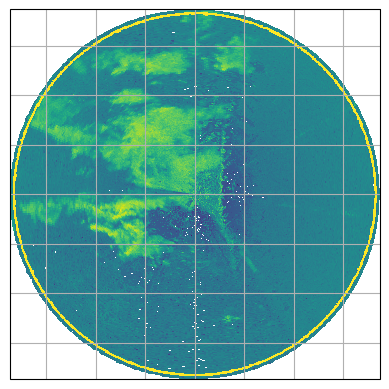

In [10]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

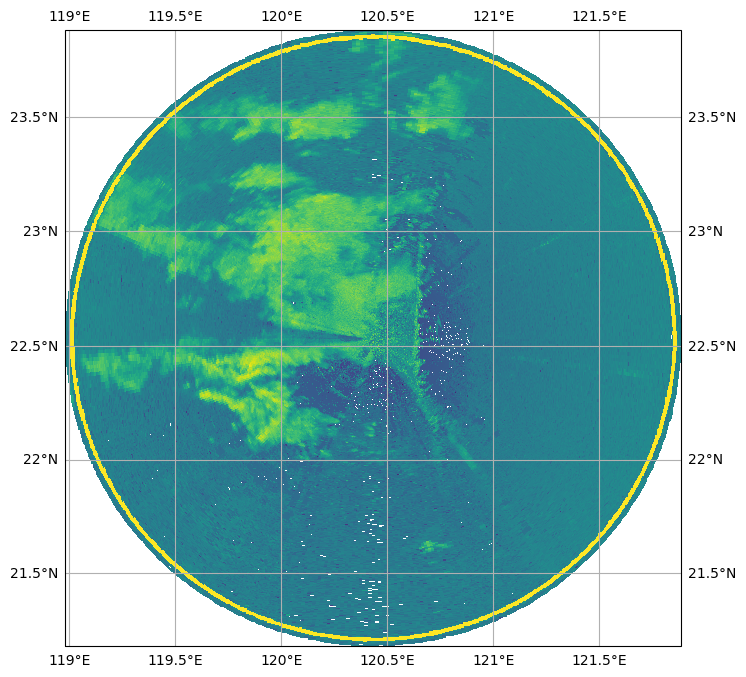

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

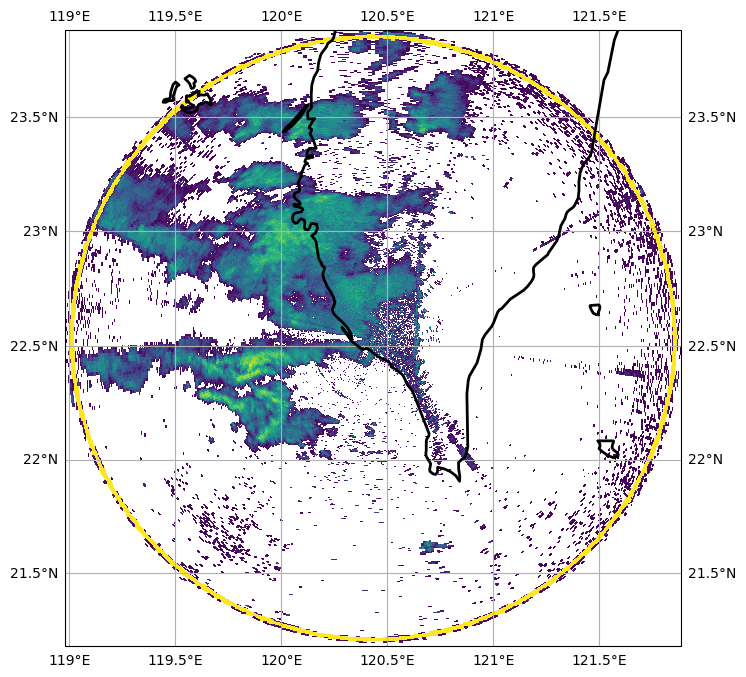

In [12]:
import cartopy.feature as cfeature


def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="physical", name="coastline", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZ = swp.DBZ
pm = DBZ.where(DBZ > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

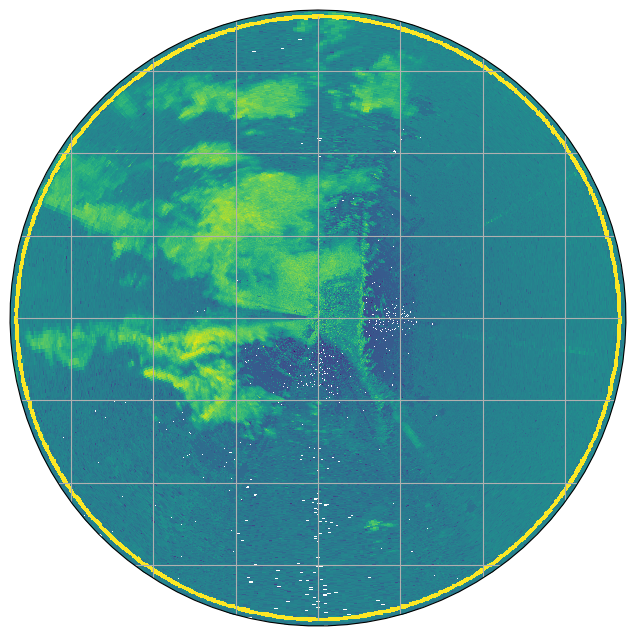

In [13]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

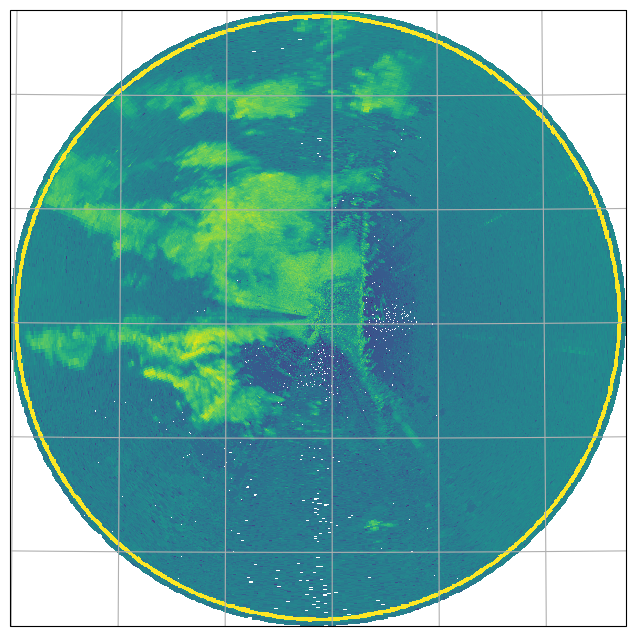

In [14]:
fig = pl.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines()

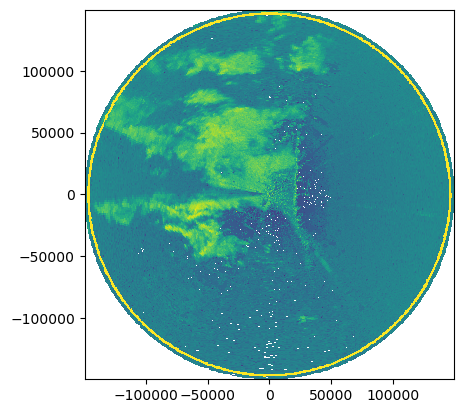

In [15]:
swp.DBZ.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial standard.

In [16]:
display(swp.DBZ)

<xarray.DataArray 'DBZ' (azimuth: 483, range: 996)>
array([[ 20.699957,  39.96934 ,  29.650644, ...,  -2.799595,  -3.549335,
         -1.650112],
       [ 13.829709,  35.710747,   8.869345, ..., -18.780428,  -3.080303,
         -4.519378],
       [ -9.129745,  14.810412,   4.539685, ...,   0.179822,  -0.550375,
         -3.519132],
       ...,
       [  5.889927,  26.049406,  32.379555, ...,  -2.550866,  -1.060269,
         -1.900617],
       [  0.959765,  23.579884,   9.29929 , ...,  -8.680257,  -5.039932,
         -2.410512],
       [ 20.079912,  39.15031 ,  13.190121, ...,  -4.91912 ,  -3.160252,
         -1.319658]], dtype=float32)
Coordinates: (12/15)
    sweep_mode  <U20 'azimuth_surveillance'
    rtime       (azimuth) datetime64[ns] 2008-06-04T00:15:34 ... 2008-06-04T0...
  * range       (range) float32 150.0 300.0 450.0 ... 1.492e+05 1.494e+05
  * azimuth     (azimuth) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
    elevation   (azimuth) float32 0.5164 0.5219 0.5164 ... 0.5219 0.5219 0.5219
    latitude    float64 22.53
    ...          ...
    x           (azimuth, range) float32 -6.556e-06 -1.311e-05 ... -1.955e+03
    y           (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.493e+05
    z           (azimuth, range) float32 46.0 47.0 48.0 ... 2.714e+03 2.718e+03
    gr          (azimuth, range) float32 150.5 300.5 ... 1.492e+05 1.494e+05
    rays        (azimuth, range) float32 0.0 0.0 0.0 0.0 ... 359.2 359.2 359.2
    bins        (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
Attributes:
    long_name:             Computed Horizontal Co-polar Reflectivit
    standard_name:         equivalent_reflectivity_factor
    units:                 dBZ
    threshold_field_name:  
    threshold_value:       -9999.0
    sampling_ratio:        1.0
    grid_mapping:          grid_mapping

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

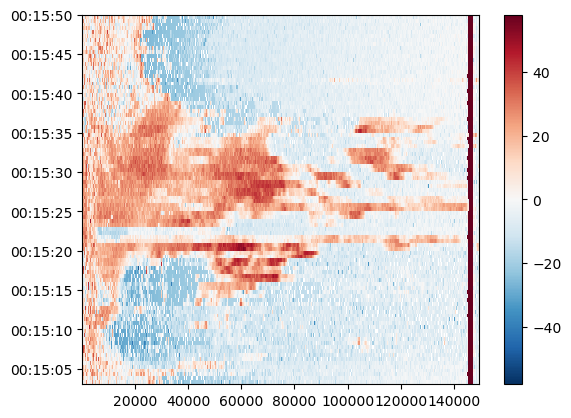

In [17]:
swp.DBZ.sortby("rtime").plot(x="range", y="rtime", add_labels=False)

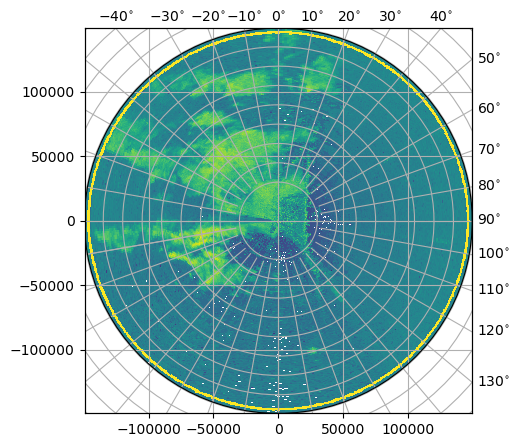

In [18]:
fig = pl.figure(figsize=(5, 5))
pm = swp.DBZ.wradlib.plot_ppi(proj={"latmin": 33e3}, fig=fig)

### Mask some values

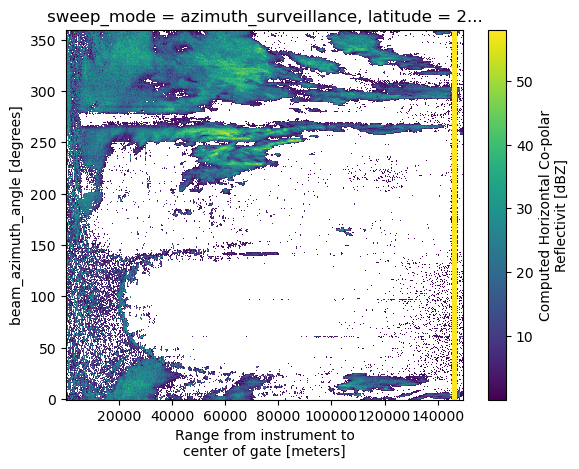

In [19]:
swp["DBZ"] = swp["DBZ"].where(swp["DBZ"] >= 0)
swp["DBZ"].plot()

### Export to ODIM and CfRadial2

In [20]:
vol.to_odim("cfradial1_as_odim.h5")
vol.to_cfradial2("cfradial1_as_cfradial2.nc")

### Import again

In [21]:
vola = wrl.io.open_odim_dataset(
    "cfradial1_as_odim.h5",
    decode_coords=True,
    backend_kwargs=dict(keep_azimuth=True, keep_elevation=True, reindex_angle=False),
)

In [22]:
volb = wrl.io.open_cfradial2_dataset("cfradial1_as_cfradial2.nc")

### Check equality

Some variables need to be dropped, since they are not exported to the other standards.

In [23]:
drop = set(vol[0]) ^ set(vola[0]) | set({"rtime"})
print(drop)
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(
    vol[0].drop_vars(drop), vola[0].drop_vars(drop, errors="ignore")
)

xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_equal(vol[0], volb[0])

xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(
    vola[0].drop_vars(drop, errors="ignore"), volb[0].drop_vars(drop, errors="ignore")
)

{'measured_transmit_power_h', 'pulse_width', 'n_samples', 'prt', 'prt_ratio', 'unambiguous_range', 'rtime', 'measured_transmit_power_v', 'scan_rate', 'antenna_transition', 'nyquist_velocity', 'r_calib_index'}


## More CfRadial1 loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

<div class="alert alert-warning">

**Warning** <br>
    
Since $\omega radlib$ version 1.18 the xarray backend engines for polar radar data have been renamed and prepended with `wradlib-` (eg. `cfradial1` -> `wradlib-cfradial1`). This was necessary to avoid clashes with the new [xradar](https://github.com/openradar/xradar)-package, which will eventually replace the wradlib engines. Users have to make sure to check which engine to use for their use-case when using `xarray.open_dataset`. Users might install and test `xradar`, and check if it is already robust enough for their use-cases (by using xradar's `engine="cfradial1"`.
    
Since $\omega radlib$ version 1.19 the xarray backend engines for polar radar data have been deprecated. The functionality is kept until wradlib version 2.0, when the backend-code will be removed completely. wradlib is importing that functionality from [xradar](https://github.com/openradar/xradar)-package whenever and wherever necessary.

Below we use a compatibility layer in wradlib to give users the chance to adapt their code. The first minimal change is that for every backend the group-layout is conforming to the CfRadial-standard naming scheme (``sweep_0``, ``sweep_1``, etc.).
    
</div>


Below you can inspect the main differences of the wradlib compatibility layer and the plain xradar implementation.

### use wradlib compatibility layer

In [24]:
swp_a = xr.open_dataset(
    f,
    engine="wradlib-cfradial1",
    group="sweep_1",
    backend_kwargs=dict(reindex_angle=False),
)
display(swp_a)

<xarray.Dataset>
Dimensions:                    (azimuth: 483, range: 996)
Coordinates:
    sweep_mode                 |S32 ...
    rtime                      (azimuth) datetime64[ns] ...
  * range                      (range) float32 150.0 300.0 ... 1.494e+05
  * azimuth                    (azimuth) float32 0.0 0.75 1.5 ... 358.5 359.2
    elevation                  (azimuth) float32 ...
    latitude                   float64 ...
    longitude                  float64 ...
    altitude                   float64 ...
    time                       datetime64[ns] ...
Data variables: (12/17)
    sweep_number               int32 ...
    prt_mode                   |S32 ...
    follow_mode                |S32 ...
    sweep_fixed_angle          float32 ...
    pulse_width                (azimuth) timedelta64[ns] ...
    prt                        (azimuth) timedelta64[ns] ...
    ...                         ...
    r_calib_index              (azimuth) int8 ...
    measured_transmit_power_h  (azimuth) float32 ...
    measured_transmit_power_v  (azimuth) float32 ...
    scan_rate                  (azimuth) float32 ...
    DBZ                        (azimuth, range) float32 ...
    VR                         (azimuth, range) float32 ...
Attributes:
    fixed_angle:  1.0986

### use xradar backend

In [25]:
swp_b = xr.open_dataset(
    f, engine="cfradial1", group="sweep_1", backend_kwargs=dict(reindex_angle=False)
)
display(swp_b)

<xarray.Dataset>
Dimensions:                    (azimuth: 483, range: 996)
Coordinates:
    time                       (azimuth) datetime64[ns] ...
  * range                      (range) float32 150.0 300.0 ... 1.494e+05
  * azimuth                    (azimuth) float32 0.0 0.75 1.5 ... 358.5 359.2
    elevation                  (azimuth) float32 ...
    latitude                   float64 ...
    longitude                  float64 ...
    altitude                   float64 ...
Data variables: (12/18)
    sweep_number               int32 ...
    sweep_mode                 |S32 ...
    prt_mode                   |S32 ...
    follow_mode                |S32 ...
    sweep_fixed_angle          float32 ...
    pulse_width                (azimuth) timedelta64[ns] ...
    ...                         ...
    r_calib_index              (azimuth) int8 ...
    measured_transmit_power_h  (azimuth) float32 ...
    measured_transmit_power_v  (azimuth) float32 ...
    scan_rate                  (azimuth) float32 ...
    DBZ                        (azimuth, range) float32 ...
    VR                         (azimuth, range) float32 ...